# 4-3 细胞扰动分析

## 1. 背景

在前面的分析教程中，我们详细研究了“不同处理下细胞的差异表达基因”，“不同处理下细胞的组成变化”。实际上，我们还会关心一个很直接的问题，那就是不同处理下，究竟什么细胞受到的影响最大。可能你会说，观察差异表达基因的数量，或者观察哪一类细胞变多了，又或者是对差异表达基因进行通路富集分析去评价通路变化。这两个思路是都是间接去反映细胞的状态，但我们希望有一个直接的评价指标，去评估不同处理后细胞的影响大小。

我们先阐明清楚“扰动”的定义，顾名思义，由外部影响所造成的细胞暂时性或永久性的改变。最常见的是CRISPR-Cas9实验带来的基因组扰动现象，其次是由外界干预所带来的转录水平或者蛋白水平的改变。尽管我们可以从实验的角度去衡量扰动的效果，但是对单细胞层面，不同细胞的扰动效果，仍有着较大的发展空间，具体来说有以下几点：

- **扰动响应**: 根据不同的外界干预方法，我们可以预测扰动后的组学特征。一般我们可以通过预测特征和真实值的相关性来评估，还可以通过表型的测量值进行评估，例如IC50，不同剂量反应下的AUC（曲线下面积），毒性等。
- **靶点和机理**: 我们通常会采用实验手段去分析药物的靶点与机理，但实际上，对于一种未知作用的化合物而言，我们分析其作用模式，也可以通过扰动响应的方式进行。
- **扰动相互作用**: 由于干预一般不是独立的，我们有时候会去预测扰动的组合效应，以了解基因组与药物组合之间的相互关联的影响。
- **化学性质**: 我们除了通过组学层特征的改变去分析药物的扰动响应外，我们也可以根据现有的化合物知识，包括R基团，药效基团等，通过已有的数据来直接预测药物的扰动效应。

而在本章教程中，我们将分析两个方面，包括`查找受扰动影响最大的细胞类型`以及`预测单细胞对扰动的转录反应`

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv
import pertpy as pt

ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.6, Tutorials: https://omicverse.readthedocs.io/


Global seed set to 0


## 2. 加载数据

我们将使用 Kang 数据集，这是一个基于 10 倍液滴的 scRNA-seq 外周血单核细胞 (PBMC) 数据集，来自 8 名狼疮患者 INF-β 治疗前后 6 小时（总共 16 个样本。

In [3]:
adata=ov.read('data/kang.h5ad')
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

我们将label重命名为condition以提高可读性，并且将`ctrl`替换成`control`,`stim`替换成`stimulated`。

In [4]:
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

该数据集包含 PBMC [ Kang等人。，2018 ]的七种不同的细胞类型。

In [5]:
adata.obs.cell_type.value_counts()

CD4 T cells          11238
CD14+ Monocytes       5697
B cells               2651
NK cells              1716
CD8 T cells           1621
FCGR3A+ Monocytes     1089
Dendritic cells        529
Megakaryocytes         132
Name: cell_type, dtype: int64

## 3. 识别受扰动影响最大的细胞类型

扰动很少对所有细胞产生相同的影响。特别是，不同的细胞类型或细胞周期中处于不同状态的细胞可能受到不同程度的影响。在这里，我们将利用Skinnidier 等人的Augur，这提供了一种量化响应程度的方法。

### 3.1 Augur模型介绍

Augur 的目标是根据细胞类型对给定单细胞基因表达数据的实验扰动的反应，对细胞类型进行排序或优先排序。基本思想是，在分子测量领域，对诱导扰动反应强烈的细胞比反应很少或没有反应的细胞类型更容易分为受扰动组和未受扰动组。通过测量每种细胞类型内实验标签（例如处理和对照）的预测程度来量化这种可分离性。这与AUC的分类方法很像，Augur 训练一个机器学习模型，在多次交叉验证运行中预测每种细胞类型的实验标签，然后根据衡量模型准确性的指标分数对细胞类型响应进行优先级排序。对于分类数据，曲线下面积是默认度量，对于数值数据，一致性相关系数用作模型精度的代理，进而近似扰动响应。

我们可以选择两种不同的分类器用作Augur的模型：

- 随机森林模型`random_forest_classifier`：用于分类数据
- 逻辑回归模型`logistic_regression_classifier`:：用于数值数据

在我们的数据中分为Control和stimulated两种类别，故我们选择随机森林模型。

In [6]:
ag_rfc = pt.tl.Augur("random_forest_classifier")
loaded_data = ag_rfc.load(adata, label_col="condition", cell_type_col="cell_type")
loaded_data

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'y_'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

### 3.2 Augur模型预测

需要注意的是，由于在Pertpy包中，Augur模型被重新实现。故在保留了Augur的原始模型外，还额外扩展了另一种运行模型，：

- `Augur原始模型`：我们可以在`predict`函数中指定参数`select_variance_feature=True`来使用该模型，该方法使用了方差来计算细胞间的基因特征，仅排除了方差较小的基因。
- `高可变基因模型`：我们还可以在`predict`函数中指定参数`select_variance_feature=False`来使用该模型，这种方法仅采用了单细胞数据中的高可变基因，大幅减少了基因数，由于高可变基因分离细胞类型相当有用，因此我们所计算出来的Augur分数偏高，作者推荐将其应用在具有扰动的非常大的数据集，这些扰动预计会对特定细胞类型产生强烈影响。

我们预计 INF-β 不会对特定细胞类型产生特殊影响，因此我们使用原始 Augur 特征选择来运行 Augur。为了进一步提高分辨率，我们将 设为subsample_size20（默认值：50），它对应于每种细胞类型随机绘制的细胞数。

In [ ]:
v_adata, v_results = ag_rfc.predict(
    loaded_data, subsample_size=20, n_threads=4, select_variance_features=True, span=1
)

In [10]:
v_results["summary_metrics"]

,CD14+ Monocytes,CD4 T cells,Dendritic cells,NK cells,CD8 T cells,B cells,FCGR3A+ Monocytes,Megakaryocytes
mean_augur_score,0.920476,0.669376,0.847007,0.673299,0.626247,0.783628,0.888934,0.512619
mean_auc,0.920476,0.669376,0.847007,0.673299,0.626247,0.783628,0.888934,0.512619
mean_accuracy,0.817033,0.601172,0.744249,0.610330,0.575714,0.674505,0.780330,0.510513
mean_precision,0.835072,0.630593,0.779699,0.642700,0.587059,0.742801,0.792996,0.526175
mean_f1,0.806636,0.564695,0.735157,0.591230,0.552114,0.633906,0.780933,0.406510
mean_recall,0.826349,0.575714,0.756032,0.616984,0.580000,0.622540,0.816508,0.388413


### 3.3 Augur模型结果解读

结果表包含拟合模型的几个评估指标。对于 IFN-β 反应的细胞类型优先顺序的解释，只有mean_augur_score相关，对应于mean_auc。值越高，拟合模型就越容易区分控制细胞状态和扰动细胞状态。因此，这种细胞类型的扰动效应更强。让我们可视化一下这个效果。

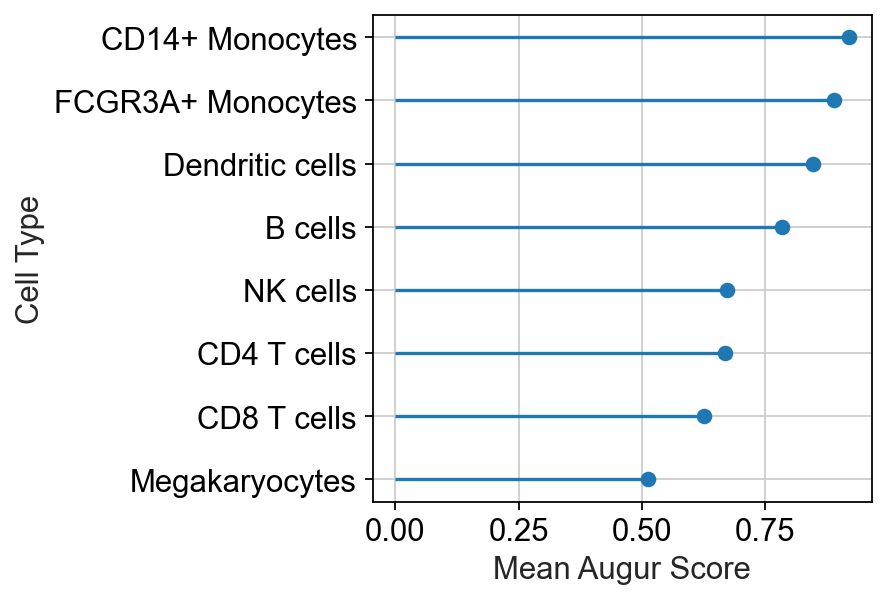

In [11]:
lollipop = pt.pl.ag.lollipop(v_results)

据观察，CD14+单核细胞受IFN-β影响最大，而巨核细胞受影响最小。这大致相当于原始论文中各细胞类型差异表达基因的数量

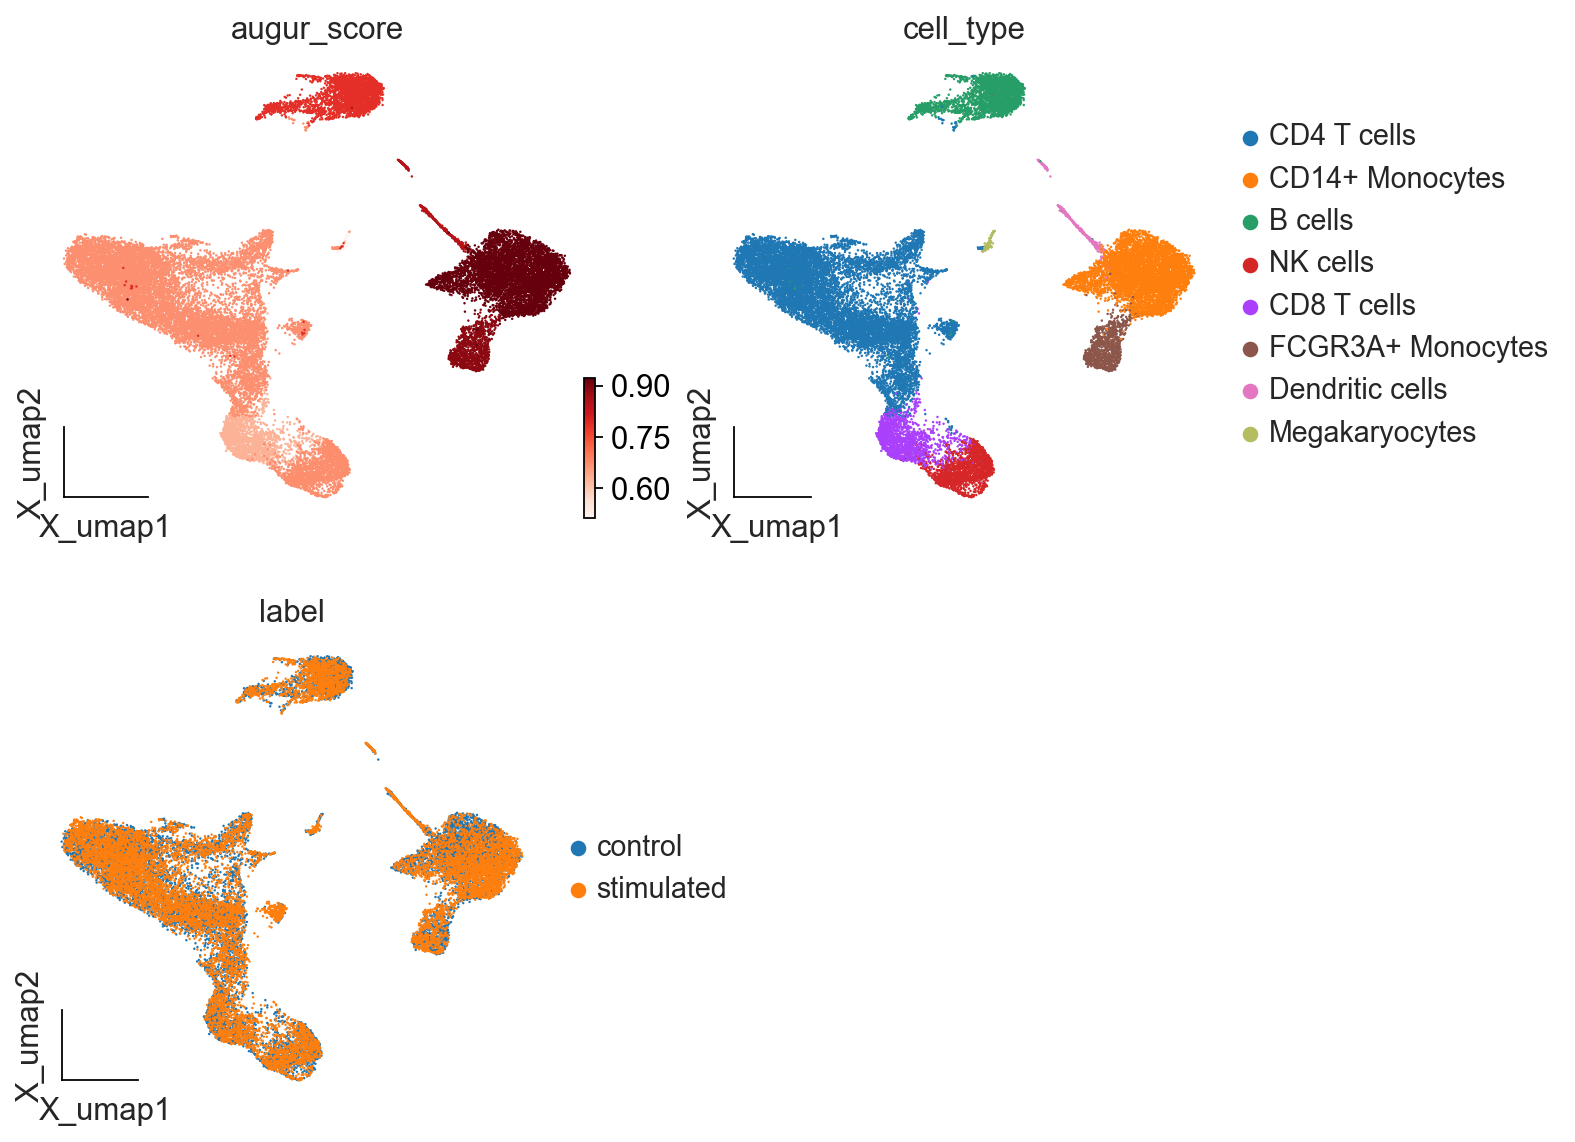

In [15]:
ov.utils.embedding(v_adata,
                   basis='X_umap',
                    frameon='small',
                   color=["augur_score", "cell_type", "label"],
                   cmap='Reds',
                   ncols=2)

### 3.4 确定扰动关键基因

可能你会觉得，既然与差异表达基因数一致，那为什么不用差异表达基因数来衡量扰动强弱，这是因为，除了关心扰动强弱外，我们还关心扰动的主要干预基因，这些基因不一定是差异表达倍数最高的基因，但他们对模型的贡献度是可以量化的。

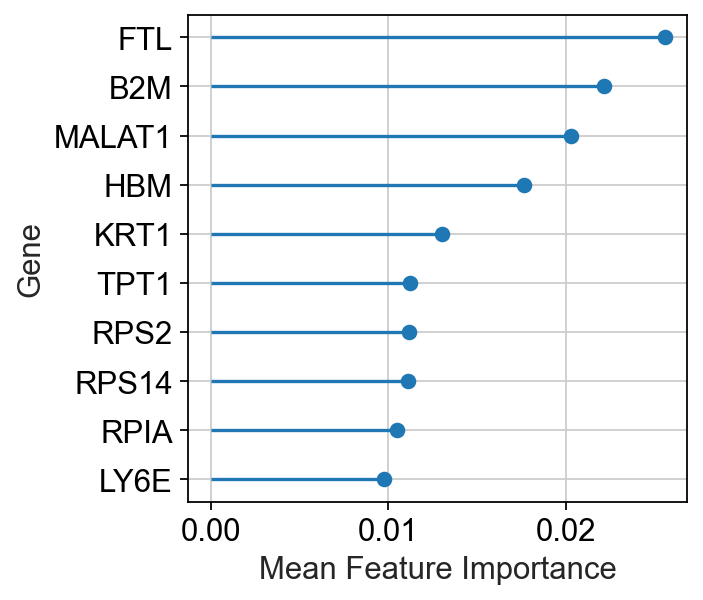

In [17]:
important_features = pt.pl.ag.important_features(v_results)

虽然这些基因在Augur模型中的贡献度较高，但是，扰动是一种生物性调控，因此，确定扰动直接干预的基因仍需进行进一步的生物学探索，而不是仅根据数据影响来确定。

### 3.5 不同处理中受扰动影响的细胞类型优先级

在上述分析中，我们仅研究了`Ctrl`和`Stim`两个组受扰动的影响，但在真实情况中，我们通常会进行多种药物处理，或者是不同时间段的药物干预分析。而在Augur中，提供了排列测试来进行差异优先级划分。

基本上，差异优先级是通过对两组细胞类型优先级之间的 AUC 差异进行排列测试来获得的，与样本标签随机排列后相同的两个优先级之间的预期 AUC 差异进行比较。在此过程中，用户首先分别对药物A  和药物B进行细胞类型优先级排序，然后计算药物 A 和药物 B 之间的 AUC 差异。为了计算 AUC 差异的统计显着性，需要使用经验零分布然后通过排列样本标签，然后在排列数据中重复细胞类型优先顺序，计算每种细胞类型的 AUC 差异。然后计算排列 P 值。因此，该程序能够识别不同条件之间细胞类型优先顺序的统计显着差异，以及细胞类型在转录上可分离程度更高的条件。

我们在这里使用另外一个数据执行扰动分析，该数据给小鼠提供可卡因，并在戒断后 48 小时（withdraw_48h_Cocaine）和 15 天（withdraw_15d_Cocaine）采集前额皮质样本进行 scRNA-seq。

数据下载地址：https://figshare.com/ndownloader/files/34526528

In [7]:
adata=ov.read('data/bhattacher.h5ad')
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
#ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
ag_rfc = pt.tl.Augur("random_forest_classifier")
sc.pp.log1p(adata)

我们分别测试`withdraw_15d_Cocaine`和`withdraw_48h_Cocaine`的augur效果

In [ ]:
# Default mode
bhattacherjee_15 = ag_rfc.load(
    adata,
    label_col='condition',
    condition_label="Maintenance_Cocaine",
    treatment_label="withdraw_15d_Cocaine",
    cell_type_col="cell_type",
)

bhattacherjee_adata_15, bhattacherjee_results_15 = ag_rfc.predict(
    bhattacherjee_15, random_state=None, 
    n_threads=4, 
)
bhattacherjee_results_15["summary_metrics"].loc["mean_augur_score"].sort_values(
    ascending=False
)

每个药物处理组在default模式中运行一次，并在permute模式中运行一次，以便我们执行排列测试。

我们对48小时组进行相同的分析

In [ ]:
# Default mode
bhattacherjee_48 = ag_rfc.load(
    adata,
    label_col='condition',
    condition_label="Maintenance_Cocaine",
    treatment_label="withdraw_48h_Cocaine",
    cell_type_col="cell_type",
)

bhattacherjee_adata_48, bhattacherjee_results_48 = ag_rfc.predict(
    bhattacherjee_48, random_state=None, 
    n_threads=4,
)

bhattacherjee_results_48["summary_metrics"].loc["mean_augur_score"].sort_values(
    ascending=False
)

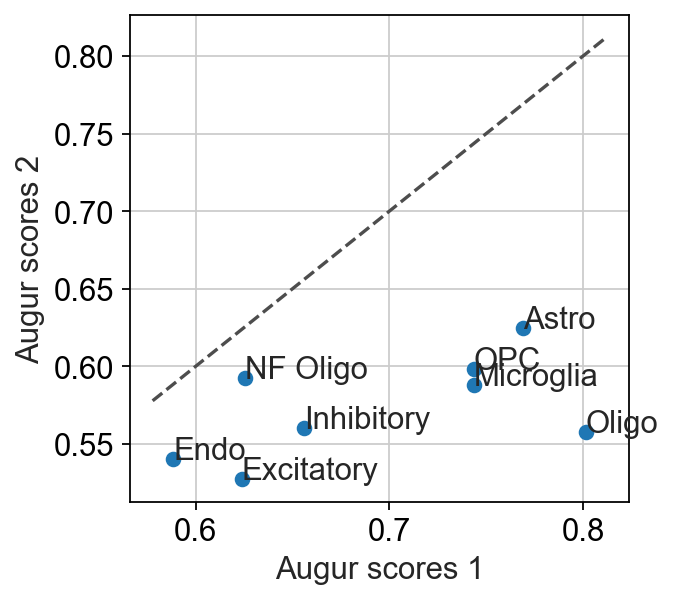

In [11]:
scatter = pt.pl.ag.scatterplot(bhattacherjee_results_15, bhattacherjee_results_48)

我们发现一个有意思的事，在15天和48小时两个组中，Oligo受干预的影响由0.8恢复至0.55，这表明Oligo会自动修复成正常的细胞状态

而设置 augur_mode = “ permute”将为每个单元格类型生成一个空的 AUC 分布，我们可以根据这个空分布去评估不同扰动下的p值情况

注意，当设置 augur_mode = “ permute”时，如果n_subsample 值小于100时，将自动设置为500

In [ ]:
# Permute mode
bhattacherjee_adata_15_permute, bhattacherjee_results_15_permute = ag_rfc.predict(
    bhattacherjee_15,
    augur_mode="permute",
    n_subsamples=100,
    random_state=None,
    n_threads=4,
)
# Permute mode
bhattacherjee_adata_48_permute, bhattacherjee_results_48_permute = ag_rfc.predict(
    bhattacherjee_48,
    augur_mode="permute",
    n_subsamples=100,
    random_state=None,
    n_threads=4,
)

In [ ]:
pvals = ag_rfc.predict_differential_prioritization(
    augur_results1=bhattacherjee_results_15,
    augur_results2=bhattacherjee_results_48,
    permuted_results1=bhattacherjee_results_15_permute,
    permuted_results2=bhattacherjee_results_48_permute,
)
pvals
diff = pt.pl.ag.dp_scatter(pvals)

由于 Augur 确定扰动响应的程度，因此它需要不同的细胞类型。如果细胞类型标记是一种持续、平稳的过程或基因表达轨迹（例如细胞分化），那么 Augur 可能不允许进行足够细粒度的排名。

## 4. 预测细胞的扰动响应

除了对已知细胞评估扰动响应外，我们还可以根据已有的细胞，预测数据集中未知的细胞的扰动响应。这种情况一般发生在：

- 细胞分选失败：扰动后没有分选到目的细胞
- 细胞捕获频率较低：这类细胞通常多次重复才能通过测序手段发现

而如果分析这类未知的细胞，我们从实验的角度，需要对样本进行重新测序，这可能带来额外的代价。而基于自编码器AE，研究人员开发了多种扰动建模的方法。在这里，我们演示scGen的应用，这是一种与向量算术相结合的变分自动编码器。该模型学习数据的潜在表示，其中估计对照（未处理）和扰动（处理）细胞之间的差异向量。然后将估计的差异向量添加到感兴趣的细胞类型或群体的对照细胞中，以预测每个单细胞的基因表达反应。

### 4.1 构建模拟数据集

我们假设CD4+ T细胞在IFN-beta治疗后没有被测序仪捕获，构建数据如下。scGen 最适合对数转换数据。由于特征空间减少，高度可变的基因选择可以加快计算速度。

In [54]:
adata=ov.read('data/kang.h5ad')
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", 
                                "stim": "stimulated"}, inplace=True)
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

Begin robust gene identification
After filtration, 15706/15706 genes are kept. Among 15706 genes, 12841 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['HBB', 'FTH1', 'MALAT1', 'HBA2', 'FTL', 'IGLL5']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


View of AnnData object with n_obs × n_vars = 24673 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [55]:
adata[adata.obs["condition"] == "stimulated"].obs.cell_type.value_counts()

CD4 T cells          5678
CD14+ Monocytes      2765
B cells              1335
NK cells              861
CD8 T cells           810
FCGR3A+ Monocytes     569
Dendritic cells       271
Megakaryocytes         69
Name: cell_type, dtype: int64

我们删除`stimulated`下的所有CD4+ T细胞，命名为`adata_t`，同时存放`stimulated`下的所有CD4+ T细胞，命名为`cd4t_stim`

In [56]:
adata_t = adata[
    ~(
        (adata.obs["cell_type"] == "CD4 T cells")
        & (adata.obs["condition"] == "stimulated")
    )
].copy()

cd4t_stim = adata[
    (
        (adata.obs["cell_type"] == "CD4 T cells")
        & (adata.obs["condition"] == "stimulated")
    )
].copy()

In [57]:
adata_t[adata_t.obs["condition"] == "stimulated"].obs.cell_type.value_counts()

CD14+ Monocytes      2765
B cells              1335
NK cells              861
CD8 T cells           810
FCGR3A+ Monocytes     569
Dendritic cells       271
Megakaryocytes         69
Name: cell_type, dtype: int64

### 4.2 构建scGEN模型并训练

scGen 需要修改后的AnnData对象 (adata_t) 来构造模型对象，该模型对象可用于训练模型。n_hidden该函数接收多个用户输入，包括bottleneck（网络的中间层）之前模型的每个hidden（ 隐藏层）中的节点数以及此类层的数量（n_layers）。此外，用户可以调整包括bottleneck的维度，该维度用于计算扰动单元和控制单元之间的差异向量。这里使用的默认参数取自原始出版物。在实践中，更宽的隐藏层可以带来更好的重建精度，这对于我们预测许多基因的扰动响应的目标至关重要。

In [58]:
import scgen
scgen.SCGEN.setup_anndata(adata_t, 
                          batch_key="condition", 
                          labels_key="cell_type")
model = scgen.SCGEN(adata_t, n_hidden=800, n_latent=100, n_layers=2)

scGen 是一个具有数千个参数的神经网络，用于学习低维数据表示。在这里，我们train使用训练数据来估计这些参数。这里有多个参数:
- max_epochs是模型允许更新参数的最大迭代次数，这里设置为100。较高值的训练纪元将花费更多计算时间，但可能有助于获得更好的结果。
- batch_size模型更新其参数的样本（单个单元）的数量。对于 scGen，较低的数字通常会带来更好的结果。
- early_stopping如果模型的结果在early_stopping_patience训练周期后没有改善，它可以使模型停止训练。早期停止机制可以防止训练数据的潜在过度拟合，从而导致对未见过的群体的泛化效果不佳。

In [59]:
model.train(
    max_epochs=100, batch_size=32, 
    early_stopping=True, early_stopping_patience=25
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 26/100:  26%|██▌       | 26/100 [02:34<07:20,  5.95s/it, loss=1.5e+03, v_num=1] 
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 3924.366. Signaling Trainer to stop.


为了可视化模型学习到的数据表示，我们使用 UMAP 算法绘制模型的潜在表示。返回get_latent_representation() 每个单元格的 100 维向量。我们将潜在表示存储在AnnData 对象的.obsm槽中。

In [60]:
adata_t.obsm["scgen"] = model.get_latent_representation()
adata_t.obsm["X_mde"]=ov.utils.mde(adata_t.obsm["scgen"])

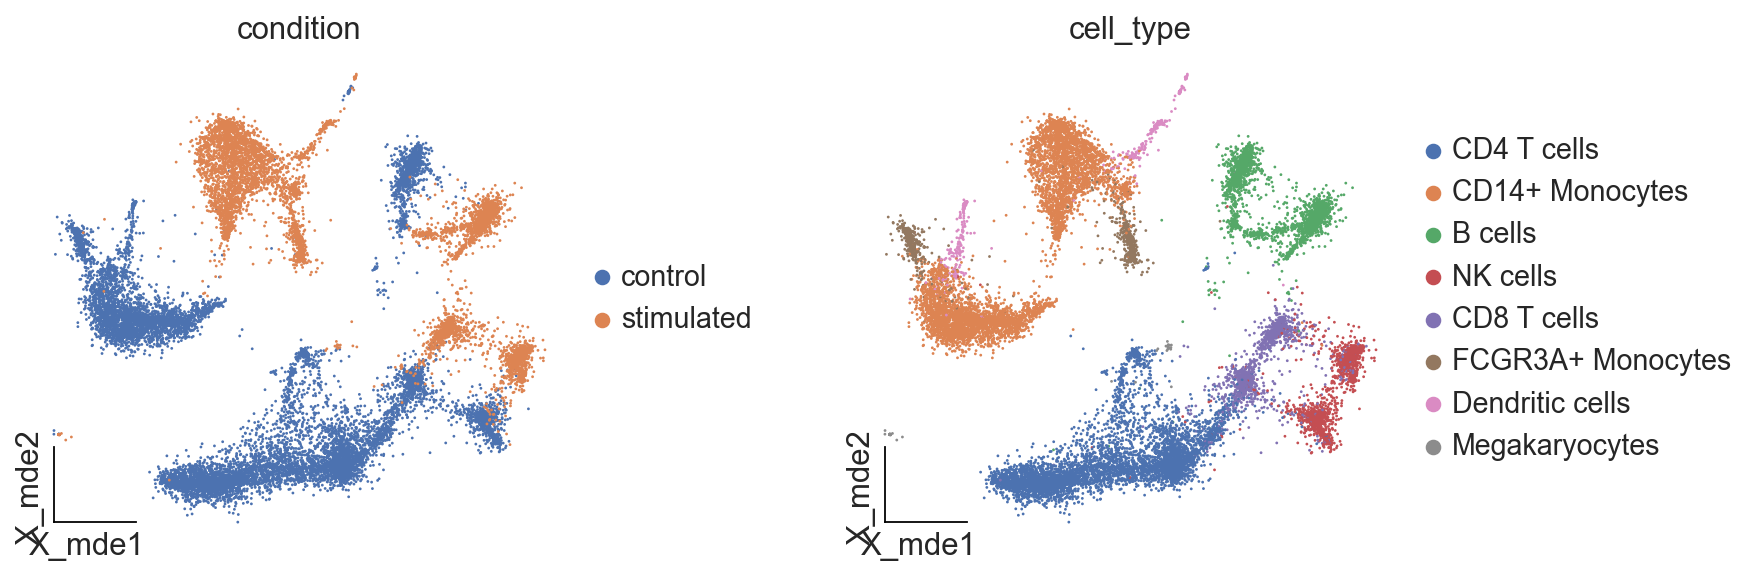

In [102]:
ov.utils.embedding(adata_t, 
           basis='X_mde',
           color=["condition", "cell_type"], 
           wspace=0.4, frameon='small')

如上所述，IFN-β 刺激诱导所有细胞类型发生强烈的转录变化

### 4.4 预测CD4+ T细胞对IFN-β刺激的反应

模型训练完成后，我们可以要求模型模拟训练数据中存在的每个对照 CD4T 细胞的 IFN-β 反应效果。通过该方法可以进行预测，该方法接收对象（如用户之前提供的）列中的predict相应标签（ctrl_key及stim_key以下），以估计“control”和“stimulated”之间的潜在空间中的全局差异向量' 细胞。然后添加到（此处为 CD4+ T）中指定的每个单细胞中。

In [62]:
pred, delta = model.predict(
    ctrl_key="control", 
    stim_key="stimulated", 
    celltype_to_predict="CD4 T cells"
)

# we annotate the predicted cells to distinguish them later from ground truth cells.
pred.obs["condition"] = "predicted stimulated"
pred

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 5560 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', '_scvi_batch', '_scvi_labels'
    var: 'name', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    obsm: 'X_pca', 'X_umap', 'scgen', 'X_mde'

### 4.5 评估预测的IFN-β刺激的CD4+ T细胞的反应

我们在前面的数据中保存了受IFN-beta刺激的CD4+ T细胞位于`cd4t_stim`对象中，我们可以对比我们预测的CD4+ T细胞与实际的CD4+ T细胞，来评估scGen预测扰动的准确性。我们将从以下几个维度来评估：

- 主成分分析空间中Control，Predicted，Actual的CD4+ T细胞的特征表示
- Predicted的刺激后CD4+ T细胞与实际的刺激后CD4+ T细胞对于Control的差异表达基因的相关性。

In [63]:
ctrl_adata = adata[
    ((adata.obs["cell_type"] == "CD4 T cells") & (adata.obs["condition"] == "control"))
]
# concatenate pred, control and real CD4 T cells in to one object
eval_adata = sc.concat([ctrl_adata,cd4t_stim, pred],merge='same')
eval_adata.obs.condition.value_counts()

stimulated              5678
control                 5560
predicted stimulated    5560
Name: condition, dtype: int64

In [101]:
ov.utils.ov_plot_set()

我们首先观察对照、IFN-β 刺激和预测的 CD4T 细胞的 PCA 共嵌入。

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


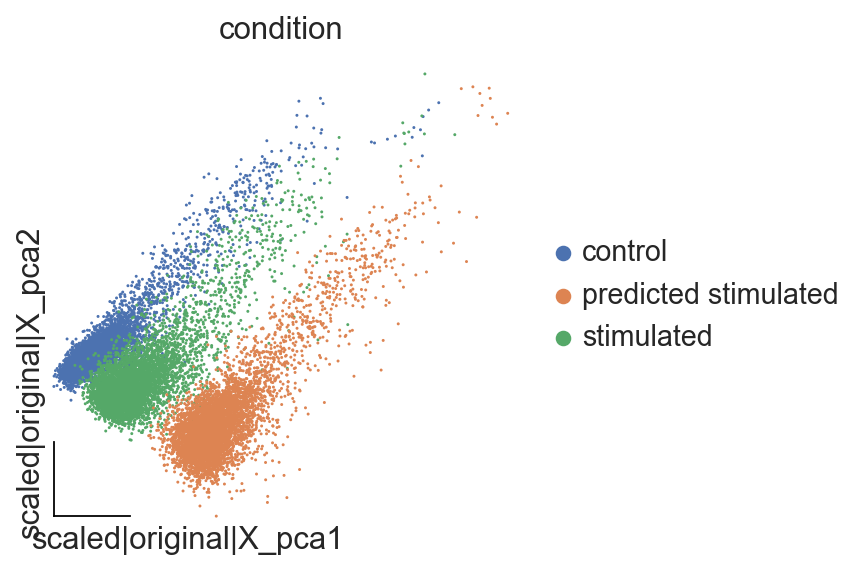

In [68]:
ov.pp.scale(eval_adata)
ov.pp.pca(eval_adata,layer='scaled',n_pcs=50)
eval_adata.obsm["X_mde_pca"]=ov.utils.mde(eval_adata.obsm["scaled|original|X_pca"])
ov.utils.embedding(eval_adata, 
                   basis='scaled|original|X_pca',
                   color="condition", 
                   frameon='small',
                  )

如上所述，预测的刺激细胞向用 IFN-β 刺激的 CD4T 细胞移动。然而，我们还应该关注差异表达基因（DEG），以验证最引人注目的 DE 基因是否也存在于预测的刺激细胞中。下面，我们看看预测细胞和真实细胞之间的总体平均相关性。在此之前，我们提取对照细胞和刺激细胞之间的 DEG

In [69]:
cd4t_adata = adata[adata.obs["cell_type"] == "CD4 T cells"]
sc.tl.rank_genes_groups(cd4t_adata, groupby="condition", method="wilcoxon")
diff_genes = cd4t_adata.uns["rank_genes_groups"]["names"]["stimulated"]
diff_genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


array(['ISG15', 'IFI6', 'ISG20', ..., 'FTH1', 'RPL10', 'RGCC'],
      dtype=object)

scGen 的函数reg_mean_plot是计算预测的 IFN-β 细胞和现有的 IFN-β 细胞的平均基因表达之间的 R² 相关性。R² 越高（最大值为 1），与实际情况相比，预测就越可信。红色突出显示的基因是 IFN-β 刺激后上调的前 10 个 DEG，这对于成功的预测至关重要。

正如所观察到的，该模型对于平均值较高的基因表现良好，而对于一些平均表达在 0-4之间的基因则失败。我们还测量了非 DEG 的准确性，因为模型不应在改变 DEG 表达的同时，把不受扰动影响的基因也改变了。

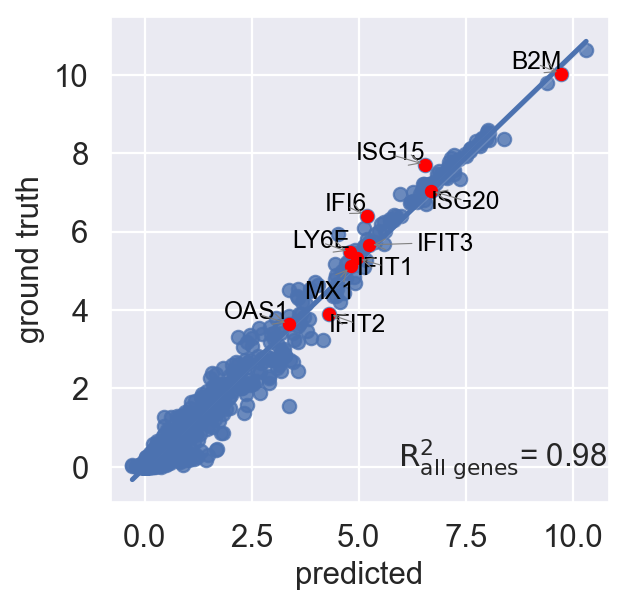

In [98]:
#eval_adata=eval_adata.raw.to_adata()
ov.plot_set()
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "predicted stimulated", "y": "stimulated"},
    gene_list=diff_genes[:10],
    #top_100_genes=list(set(diff_genes) & set(eval_adata.var_names)),
    labels={"x": "predicted", "y": "ground truth"},
    show=True,
    legend=False,
    x_coeff=0.98,
    y_coeff=1
)

我们还可以观察 IFN-β 最上调基因的分布。例如，我们绘制了ISG15的表达分布，这是IFN刺激后诱导的基因 。正如所观察到的，该模型确定该基因在用 IFN-β 刺激后应该上调，并且它确实将值转移到真实（刺激）细胞中的类似范围。

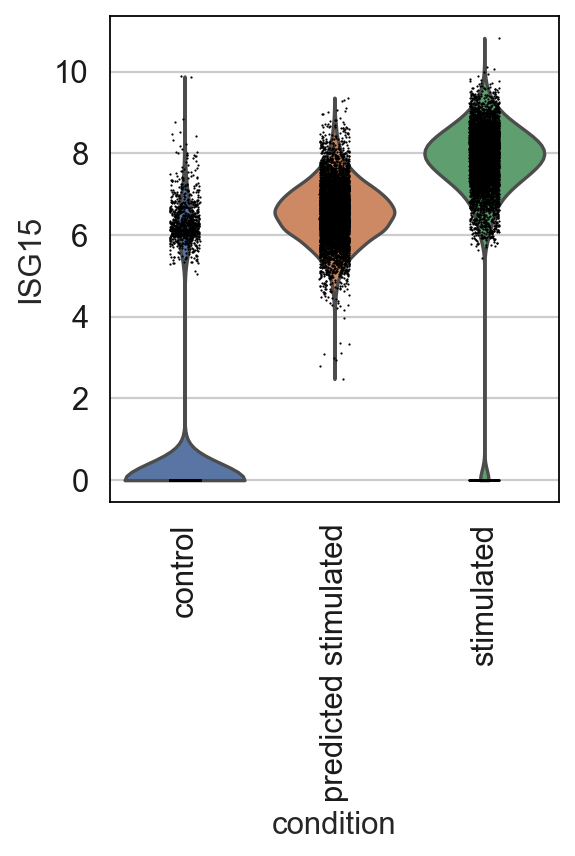

In [107]:
import matplotlib.pyplot as plt
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition",show=False)
plt.xticks(rotation=90)
plt.show()

总体而言，我们展示了 scGen 作为扰动响应模型的示例在预测所需扰动下未见群体的基因表达中的应用。虽然扰动响应模型提供了计算机预测，但它们不能代替实际实验。还不清楚预测的反应有多少归因于细胞类型特异性反应或跨细胞类型。然而，正如在 scGen 的情况下观察到的那样，它可以预测高表达基因的总体反应，但对低表达基因的预测效果较差，这需要进一步优化和动力来开发更复杂和稳健的方法。

## 5. 总结

- 应用 Augur 时，确保可以细胞类型的清晰可分离的，进而使用差异丰度测试来查找混杂效应，除此之外，我们还可以使用差异基因表达来查找扰动效应的基因水平来源。
- 使用 scGen 等工具预测扰动响应对于高表达基因效果很好，但对于低表达基因则具有一定的困难。

## 6. 思考

- 为什么应用 Augur 时需要有可靠的细胞类型标签？
- 为什么 scGen 主要只应用于高表达基因？